# Time Series Classification : Feature Creation/Extraction

### An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.api as sm
from scipy import stats
from collections import OrderedDict
import warnings
from collections import Counter

import scikits.bootstrap as bootstrap
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.exceptions import ConvergenceWarning


# (a) 

---

# (b) 
### Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [2]:
# AReM Data File path
Base_path = Path("../data/AReM")
# setting the different dataset
test_set_2_files = ["bending1", "bending2"]
# directory list
dir_list = [dir for dir in Base_path.iterdir() if dir.is_dir()]

testingData = pd.DataFrame()
trainingData = pd.DataFrame()

# concatenating every data step by step
for dir in dir_list:
    dir_path = Base_path / dir.name
    nFile = len(os.listdir(dir_path))

    if dir.name in test_set_2_files:
        test_cutoff = 2
    else:
        test_cutoff = 3

    for i in range(1, nFile + 1):
        file_path = dir_path / f"dataset{i}.csv"
        data = pd.read_csv(file_path, skiprows=4)
        if i <= test_cutoff:
            testingData = pd.concat([testingData, data], axis=0)
        else:
            trainingData = pd.concat([trainingData, data], axis=0)


In [3]:
print("Training Data Shape:", trainingData.shape)
print("Testing Data Shape:", testingData.shape)

Training Data Shape: (33119, 7)
Testing Data Shape: (9120, 7)


---

# (c) Feature Extraction
## Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

### Typical Time-Domain Features:

##### - Minimum value (min)
##### - Maximum value (max)
##### - Mean (average)
##### - Median
##### - Standard deviation (std)
##### - Variance
##### - First quartile (25th percentile)
##### - Third quartile (75th percentile)
##### - Cross-Correlations between each dimension and the Auto-Correlations
##### - Orders of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model
##### - Parameters of the AR part
##### - Parameters of the MA part

### Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# define a function to extract time-domain features
def feature_extraction(df):
    features = pd.DataFrame()
    features['min'] = df.min(axis=0)
    features['max'] = df.max(axis=0)
    features['mean'] = df.mean(axis=0)
    features['median'] = df.median(axis=0)
    features['std'] = df.std(axis=0)
    features['q1'] = df.quantile(0.25, axis=0)
    features['q3'] = df.quantile(0.75, axis=0)
    return features

dir_list = [dir for dir in Base_path.iterdir() if dir.is_dir()]

# create a feature table to accommodate all time-domain features
feature_columns = ["min1", "max1", "mean1", "median1", "std1", "1st quart1", "3rd quart1",
                           "min2", "max2", "mean2", "median2", "std2", "1st quart2", "3rd quart2",
                           "min3", "max3", "mean3", "median3", "std3", "1st quart3", "3rd quart3",
                           "min4", "max4", "mean4", "median4", "std4", "1st quart4", "3rd quart4",
                           "min5", "max5", "mean5", "median5", "std5", "1st quart5", "3rd quart5",
                           "min6", "max6", "mean6", "median6", "std6", "1st quart6", "3rd quart6"]
featuresTable = pd.DataFrame(columns=feature_columns, index=[])

# extract features and insert into features table
n = 0
for dir in dir_list:
    dir_path = Base_path / dir.name
    nFile = len(os.listdir(dir_path))
    
    for i in range(1, nFile + 1):
        
        file_path = dir_path / f"dataset{i}.csv"
        data = pd.read_csv(file_path, skiprows=4)
        data = data.drop(columns=["# Columns: time"])

        featuresData = feature_extraction(data)

        flat_features = []
        for j in range(6):
            flat_features.extend(featuresData.iloc[j].values)
        
        featuresTable = pd.concat([featuresTable, pd.DataFrame(columns=feature_columns)])
        featuresTable.loc[n] = flat_features
        n += 1

instance = range(1, 89)
featuresTable = pd.concat([pd.DataFrame(instance, columns=["instance"]), featuresTable], axis=1)

print(featuresTable)

    instance   min1   max1      mean1  median1      std1  1st quart1  \
0          1  37.25  45.00  40.624792    40.50  1.476967     39.2500   
1          2  38.00  45.67  42.812812    42.50  1.435550     42.0000   
2          3  35.00  47.40  43.954500    44.33  1.558835     43.0000   
3          4  33.00  47.75  42.179812    43.50  3.670666     39.1500   
4          5  33.00  45.75  41.678063    41.75  2.243490     41.3300   
..       ...    ...    ...        ...      ...       ...         ...   
83        84  27.00  44.33  36.541667    36.00  4.018922     33.2500   
84        85  18.50  44.25  35.752354    36.00  4.614802     33.0000   
85        86  19.00  43.75  35.879875    36.00  4.614878     33.0000   
86        87  23.33  43.50  36.244083    36.75  3.822016     33.4575   
87        88  24.25  45.00  37.177042    36.25  3.581301     34.5000   

    3rd quart1  min2   max2  ...      std5  1st quart5  3rd quart5  min6  \
0      42.0000   0.0   1.30  ...  2.188449     33.0000     

---

### Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)

df_features_est = featuresTable.drop(columns=["instance"])

df_std = df_features_est.std(axis=0).round(4)
display(df_std)

min1          9.6240
max1          4.2077
mean1         5.2764
median1       5.3866
std1          1.7713
1st quart1    6.1278
3rd quart1    5.0310
min2          0.0000
max2          5.0597
mean2         1.5779
median2       1.4135
std2          0.8859
1st quart2    0.9484
3rd quart2    2.1313
min3          2.9545
max3          4.8198
mean3         3.9768
median3       4.0097
std3          0.9520
1st quart3    4.1841
3rd quart3    4.1535
min4          0.0000
max4          2.1818
mean4         1.1683
median4       1.1486
std4          0.4586
1st quart4    0.8449
3rd quart4    1.5552
min5          6.1212
max5          5.7734
mean5         5.7040
median5       5.8444
std5          1.0124
1st quart5    6.1221
3rd quart5    5.5636
min6          0.0461
max6          2.5335
mean6         1.1572
median6       1.0899
std6          0.5170
1st quart6    0.7615
3rd quart6    1.5269
dtype: float64

In [6]:
# plot the 90% confidence interval 
confid_level = 0.90
confidence_interval = pd.DataFrame(columns=['Feature', 'Lower Bound', 'Upper Bound'])

for col in df_features_est.columns:
    data = df_features_est[col].dropna().values
    ci = bootstrap.ci(data, statfunction=np.std, alpha=1-confid_level)
    temp = pd.DataFrame({'Feature': [col], 'Lower Bound': [ci[0].round(6)], 'Upper Bound': [ci[1].round(6)]})
    confidence_interval = pd.concat([confidence_interval, temp], ignore_index=True)

display(confidence_interval)

/opt/anaconda3/lib/python3.13/site-packages/scikits/bootstrap/bootstrap.py:443: InstabilityWarning: BCa acceleration values for indices (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  avals = _avals_bca(
/var/folders/qw/mp41sv_d0cg6qhwh591310k80000gn/T/ipykernel_15743/3841893985.py:7: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  ci = bootstrap.ci(data, statfunction=np.std, alpha=1-confid_level)
/opt/anaconda3/lib/python3.13/site-packages/scikits/bootstrap/bootstrap.py:443: InstabilityWarning: BCa acceleration values for indices (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  avals = _avals_bca(
/var/folders/qw/mp41sv_d0cg6qhwh591310k80000gn/T/ipykernel_15743/3841893985.py:7: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  ci = bootstrap.ci(data, statfunctio

Feature  Lower Bound  Upper Bound
0         min1     8.557792    11.217461
1         max1     3.350163     5.385721
2        mean1     4.738520     5.974649
3      median1     4.820344     6.058430
4         std1     1.599544     1.985768
5   1st quart1     5.606748     6.701737
6   3rd quart1     4.348712     5.892651
7         min2     0.000000     0.000000
8         max2     4.673387     5.426724
9        mean2     1.416311     1.711602
10     median2     1.247939     1.547120
11        std2     0.810951     0.943774
12  1st quart2     0.846149     1.045030
13  3rd quart2     1.914744     2.302628
14        min3     2.777091     3.121695
15        max3     4.190856     5.511932
16       mean3     3.448278     4.533520
17     median3     3.447083     4.568124
18        std3     0.808426     1.212516
19  1st quart3     3.650738     4.732629
20  3rd quart3     3.596466     4.756232
21        min4     0.000000     0.000000
22        max4     1.998963     2.395199
23       mean4     1.081722     1.219960
24     median4     1.060711     1.200954
25        std4     0.424975     0.487430
26  1st quart4     0.779103     0.890600
27  3rd quart4     1.433125     1.622245
28        min5     4.711862     7.849461
29        max5     4.917105     6.743626
30       mean5     4.624832     6.985644
31     median5     4.761053     7.159602
32        std5     0.845819     1.278858
33  1st quart5     5.037746     7.489559
34  3rd quart5     4.564231     6.750005
35        min6     0.000000     0.064443
36        max6     2.309403     2.841584
37       mean6     1.068984     1.213871
38     median6     1.003214     1.149803
39        std6     0.482379     0.546355
40  1st quart6     0.697100     0.811493
41  3rd quart6     1.411353     1.598698

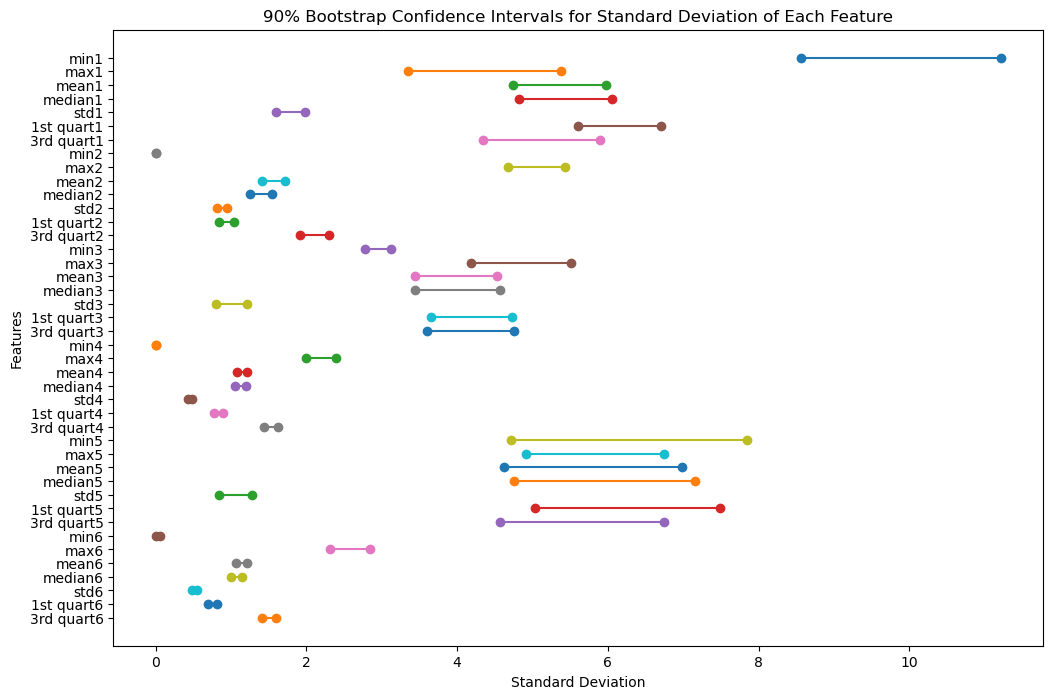

In [7]:
plt.figure(figsize=(12, 8))
for i in range(0, len(df_features_est.columns)):
    plt.plot((confidence_interval.iloc[i]['Lower Bound'], confidence_interval.iloc[i]['Upper Bound']), (i, i),
             marker='o')
plt.title('90% Bootstrap Confidence Intervals for Standard Deviation of Each Feature')
plt.xlabel('Standard Deviation')
plt.ylabel('Features')
plt.yticks(range(0, len(df_features_est.columns)), df_features_est.columns)
plt.gca().invert_yaxis()
plt.show()

##### 1. "mean", "std", and "median" has smaller standard deviation and confidence interval than other features
##### 2. "mean" can help us directly observe the central tendency of the dataset
##### 3. "std" can show the despersion of dataset, that is, how widely or narrowly the data are spread.
##### 4. "median" can show the middle place of the dataset. Besides, it's not affecting by outliers.
---

# Time Series Classification : Binary and Multiclass Classification

In [8]:
# defining a function to build feature extraction data(without spliting time)

class FeatExtrac():
    
    def __init__(self, base_path_str="../data/AReM"):
        self.BasePath = Path(base_path_str)
        self.dir_list = [d for d in self.BasePath.iterdir() if d.is_dir()]

        self.actName = [os.path.basename(os.path.normpath(d)) for d in self.dir_list]
        
        self.DirPath = {}
        for d in self.dir_list:
            activity = os.path.basename(os.path.normpath(d))
            self.DirPath[activity] = d

    def get_train_featextrac(self):
        feature_columns = ["min1", "max1", "mean1", "median1", "std1", "1st quart1", "3rd quart1",
                           "min2", "max2", "mean2", "median2", "std2", "1st quart2", "3rd quart2",
                           "min3", "max3", "mean3", "median3", "std3", "1st quart3", "3rd quart3",
                           "min4", "max4", "mean4", "median4", "std4", "1st quart4", "3rd quart4",
                           "min5", "max5", "mean5", "median5", "std5", "1st quart5", "3rd quart5",
                           "min6", "max6", "mean6", "median6", "std6", "1st quart6", "3rd quart6",
                           "label"]
        featuresTable = pd.DataFrame(columns=feature_columns, index=[])

        n = 0

        for key, value in self.DirPath.items():
            # setting mark_N for selecting training and testing set
            if key in ['bending1', 'bending2']:
                mark_N = 3
                label = 'bending'
            else:
                mark_N = 4
                label = 'other'

            nFile = len(os.listdir(value))
            for i in range(mark_N, nFile+1):
                file_path = value / f"dataset{i}.csv"
                data = pd.read_csv(file_path, skiprows=5, sep=r'[,\s]+', header=None, engine='python')
                data = data.drop(columns=[0])

                featuresData = feature_extraction(data)

                flat_features = []
                for j in range(6):
                    flat_features.extend(featuresData.iloc[j].values)
                flat_features.append(label)
                
                featuresTable = pd.concat([featuresTable, pd.DataFrame(columns=feature_columns)])
                featuresTable.loc[n] = flat_features
                n += 1
        
        n_dtFeat = len(featuresTable)
        instance = range(1, n_dtFeat+1)
        featuresTable = pd.concat([pd.DataFrame(instance, columns=["instance"]), featuresTable], axis=1)
        return featuresTable
    

In [9]:
FE = FeatExtrac()
df_train_feature = FE.get_train_featextrac()

### (a) Binary Classification Using Logistic Regression

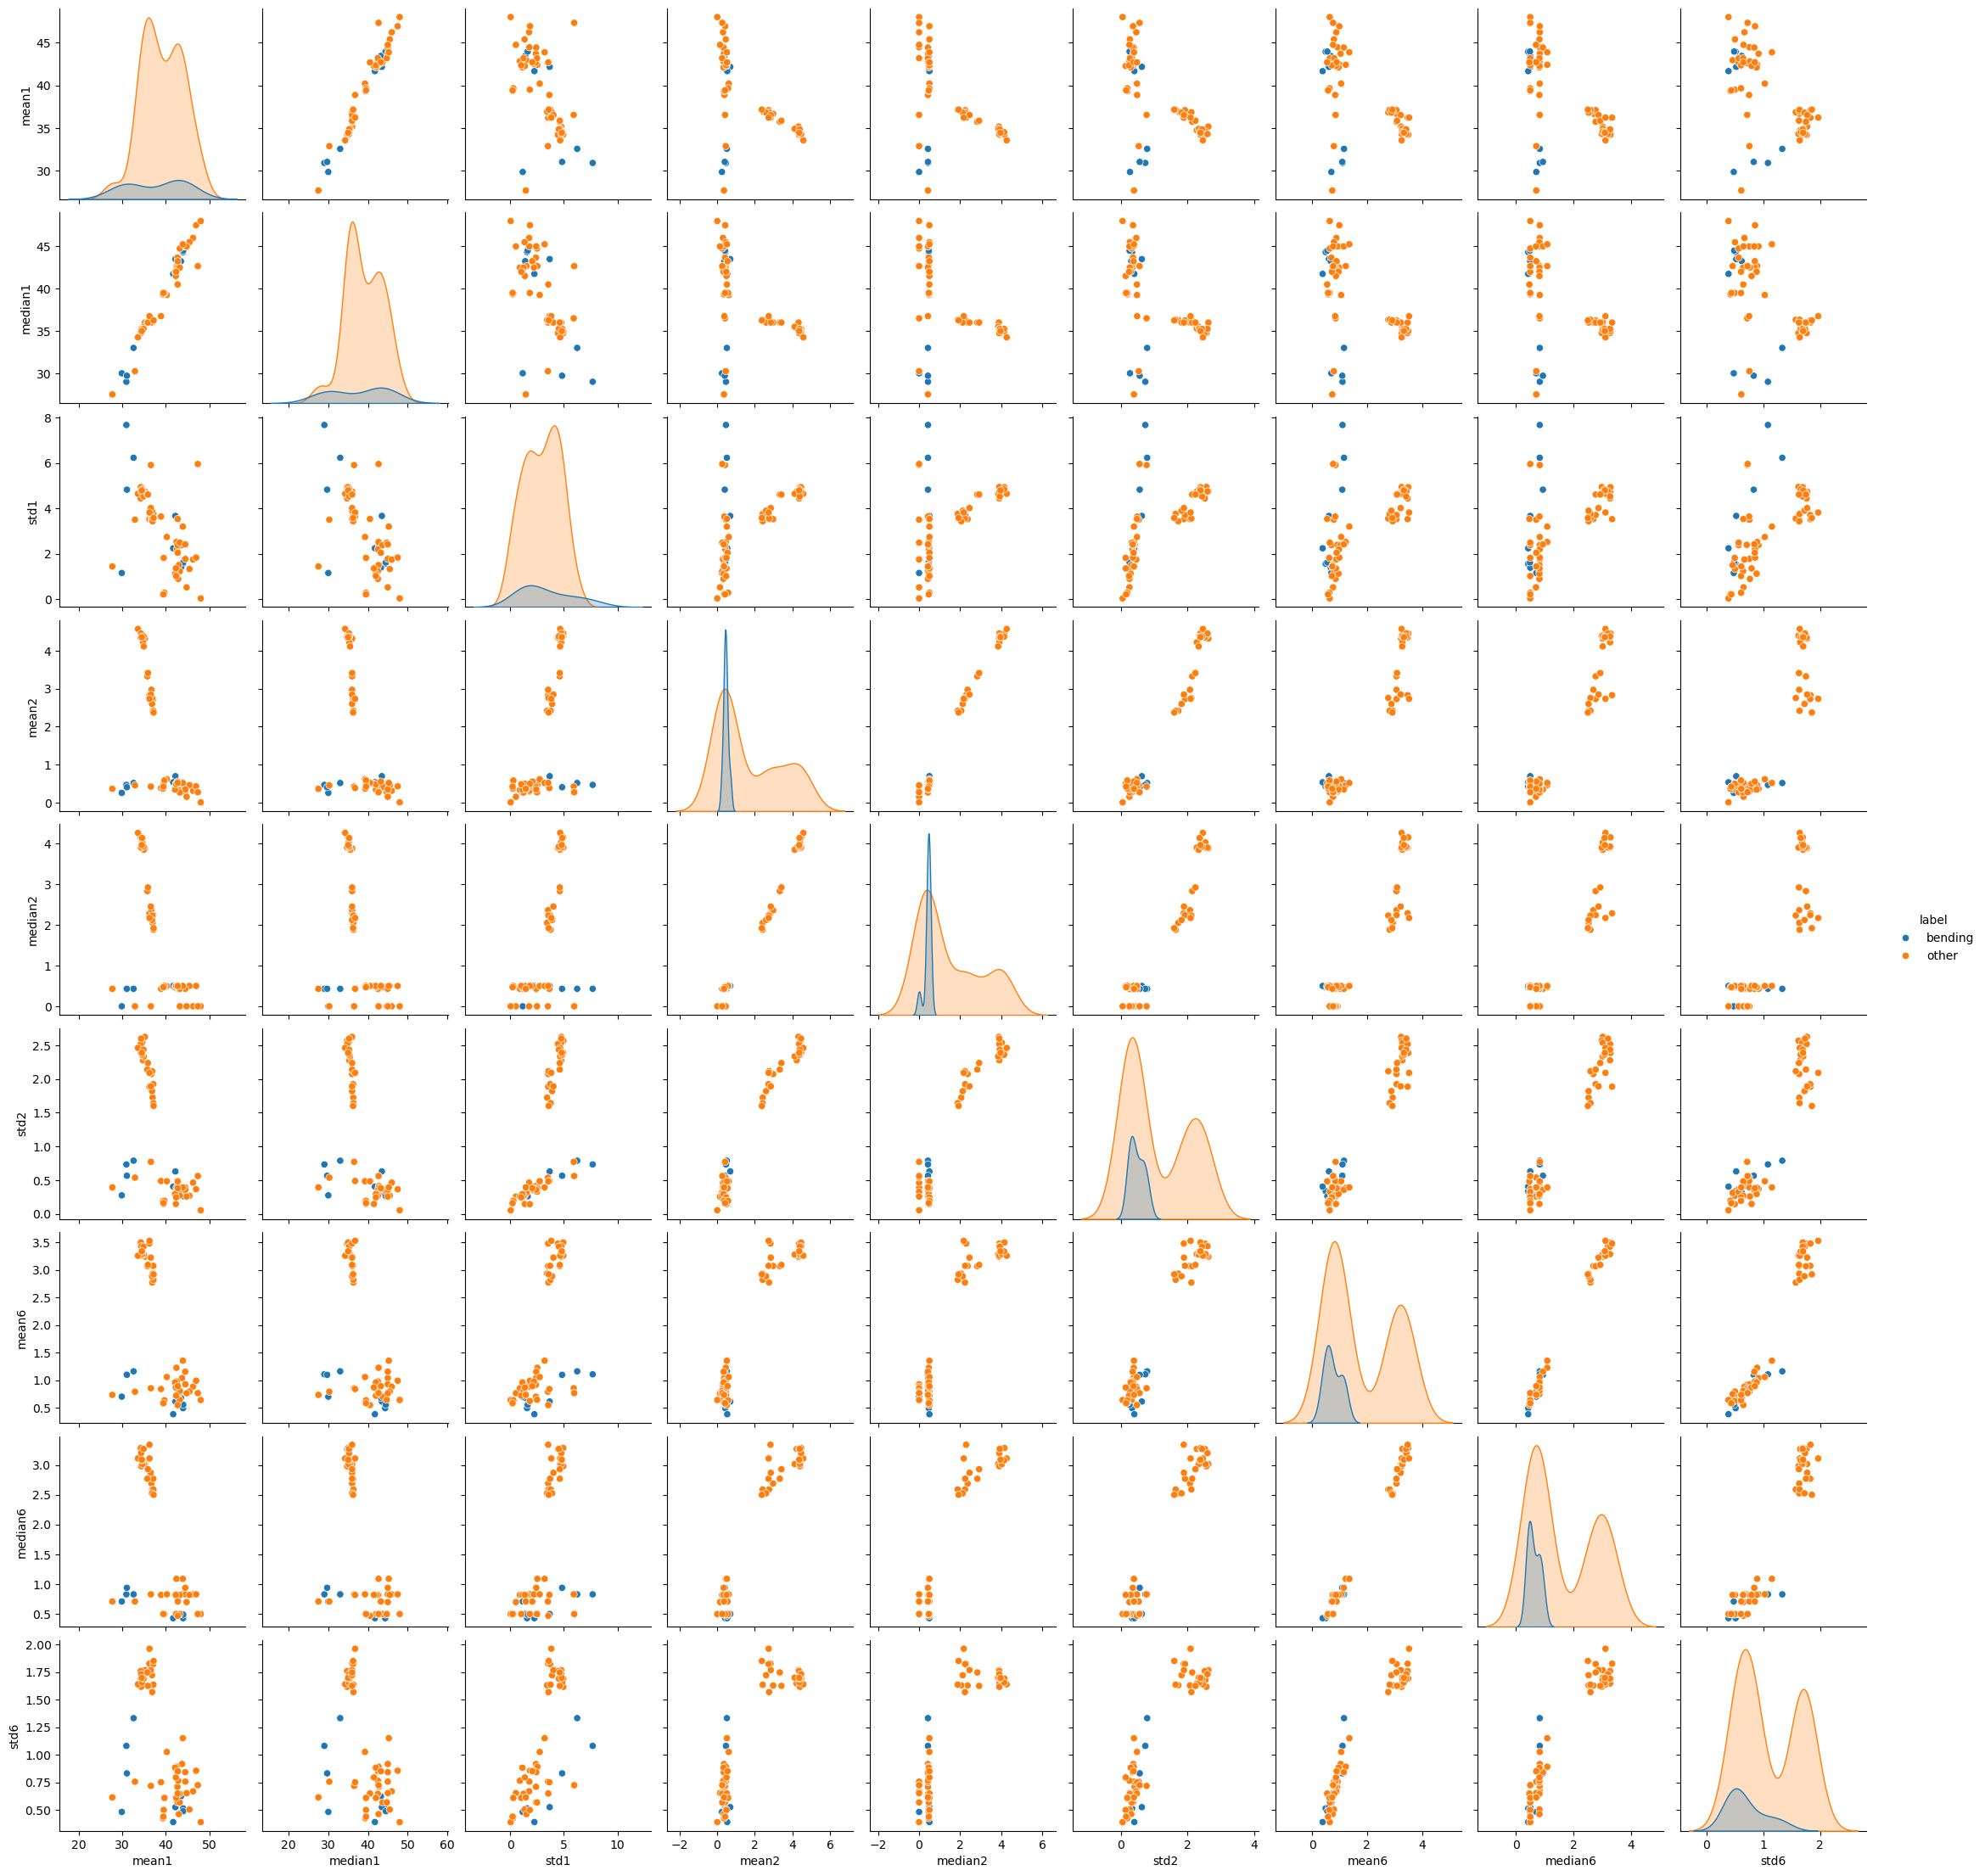

In [10]:
cols = ['mean1', 'median1', 'std1',
		'mean2', 'median2', 'std2',
		'mean6', 'median6', 'std6']

if 'label' in df_train_feature.columns:
	df = df_train_feature[cols + ['label']]
	sns.pairplot(df, hue='label')
else:
	df = df_train_feature[cols]
	sns.pairplot(df)

---

In [11]:
# defining a function to satisfy spliting data into multiple series and change into extraction data.
class FeatExtrac():
    
    def __init__(self, base_path_str="../data/AReM"):
        self.BasePath = Path(base_path_str)
        self.dir_list = [d for d in self.BasePath.iterdir() if d.is_dir()]

        self.actName = [os.path.basename(os.path.normpath(d)) for d in self.dir_list]
        
        self.DirPath = {}
        for d in self.dir_list:
            activity = os.path.basename(os.path.normpath(d))
            self.DirPath[activity] = d
        

    def get_features(self, data_type='train', l=1):
        """
        Extracts features (mean, median, std) from time series data.

        Args:
            data_type (str): 'train' or 'test' to specify which dataset to process.
            l (int): The number of segments to split each time series into. 
                     Default is 1 (no split).

        Returns:
            pandas.DataFrame: A DataFrame containing the extracted features and the 'label' column.
        """
        
        feature_names = ["mean", "median", "std"]
 
        feature_columns = []
        for i in range(1, 7): 
            for j in range(1, l + 1): 
                for feat in feature_names:
                    feature_columns.append(f"{feat}{i}_seg{j}")
        
        all_data_list = [] 

        for activity, path in self.DirPath.items():
            if activity in ['bending1', 'bending2']:
                file_indices = range(3, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 3)
                label = 'bending'
            else:
                file_indices = range(3, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 3)
                label = 'other'

            for i in file_indices:
                file_path = path / f"dataset{i}.csv"
     
                data = pd.read_csv(file_path, skiprows=5, sep=r'[,\s]+', header=None, engine='python')
                data = data.drop(columns=[0])

                instance_features = []
                
                for col_name in data.columns:
                    time_series = data[col_name]
                    
                    if l > 1:
                        segments = np.array_split(time_series, l)
                    else:
                        segments = [time_series]
                    
                    for seg in segments:
                        feats = [seg.mean(), seg.median(), seg.std()]
                        instance_features.extend(feats)
                        
                all_data_list.append(instance_features + [label])
        
        final_columns = feature_columns + ['label']

        features_df = pd.DataFrame(all_data_list, columns=final_columns)
        
        # features_df.insert(0, 'instance', range(1, len(features_df) + 1))
        
        return features_df

In [12]:
FE = FeatExtrac(base_path_str="../data/AReM")
df_train_feature = FE.get_features(data_type='train', l=1)

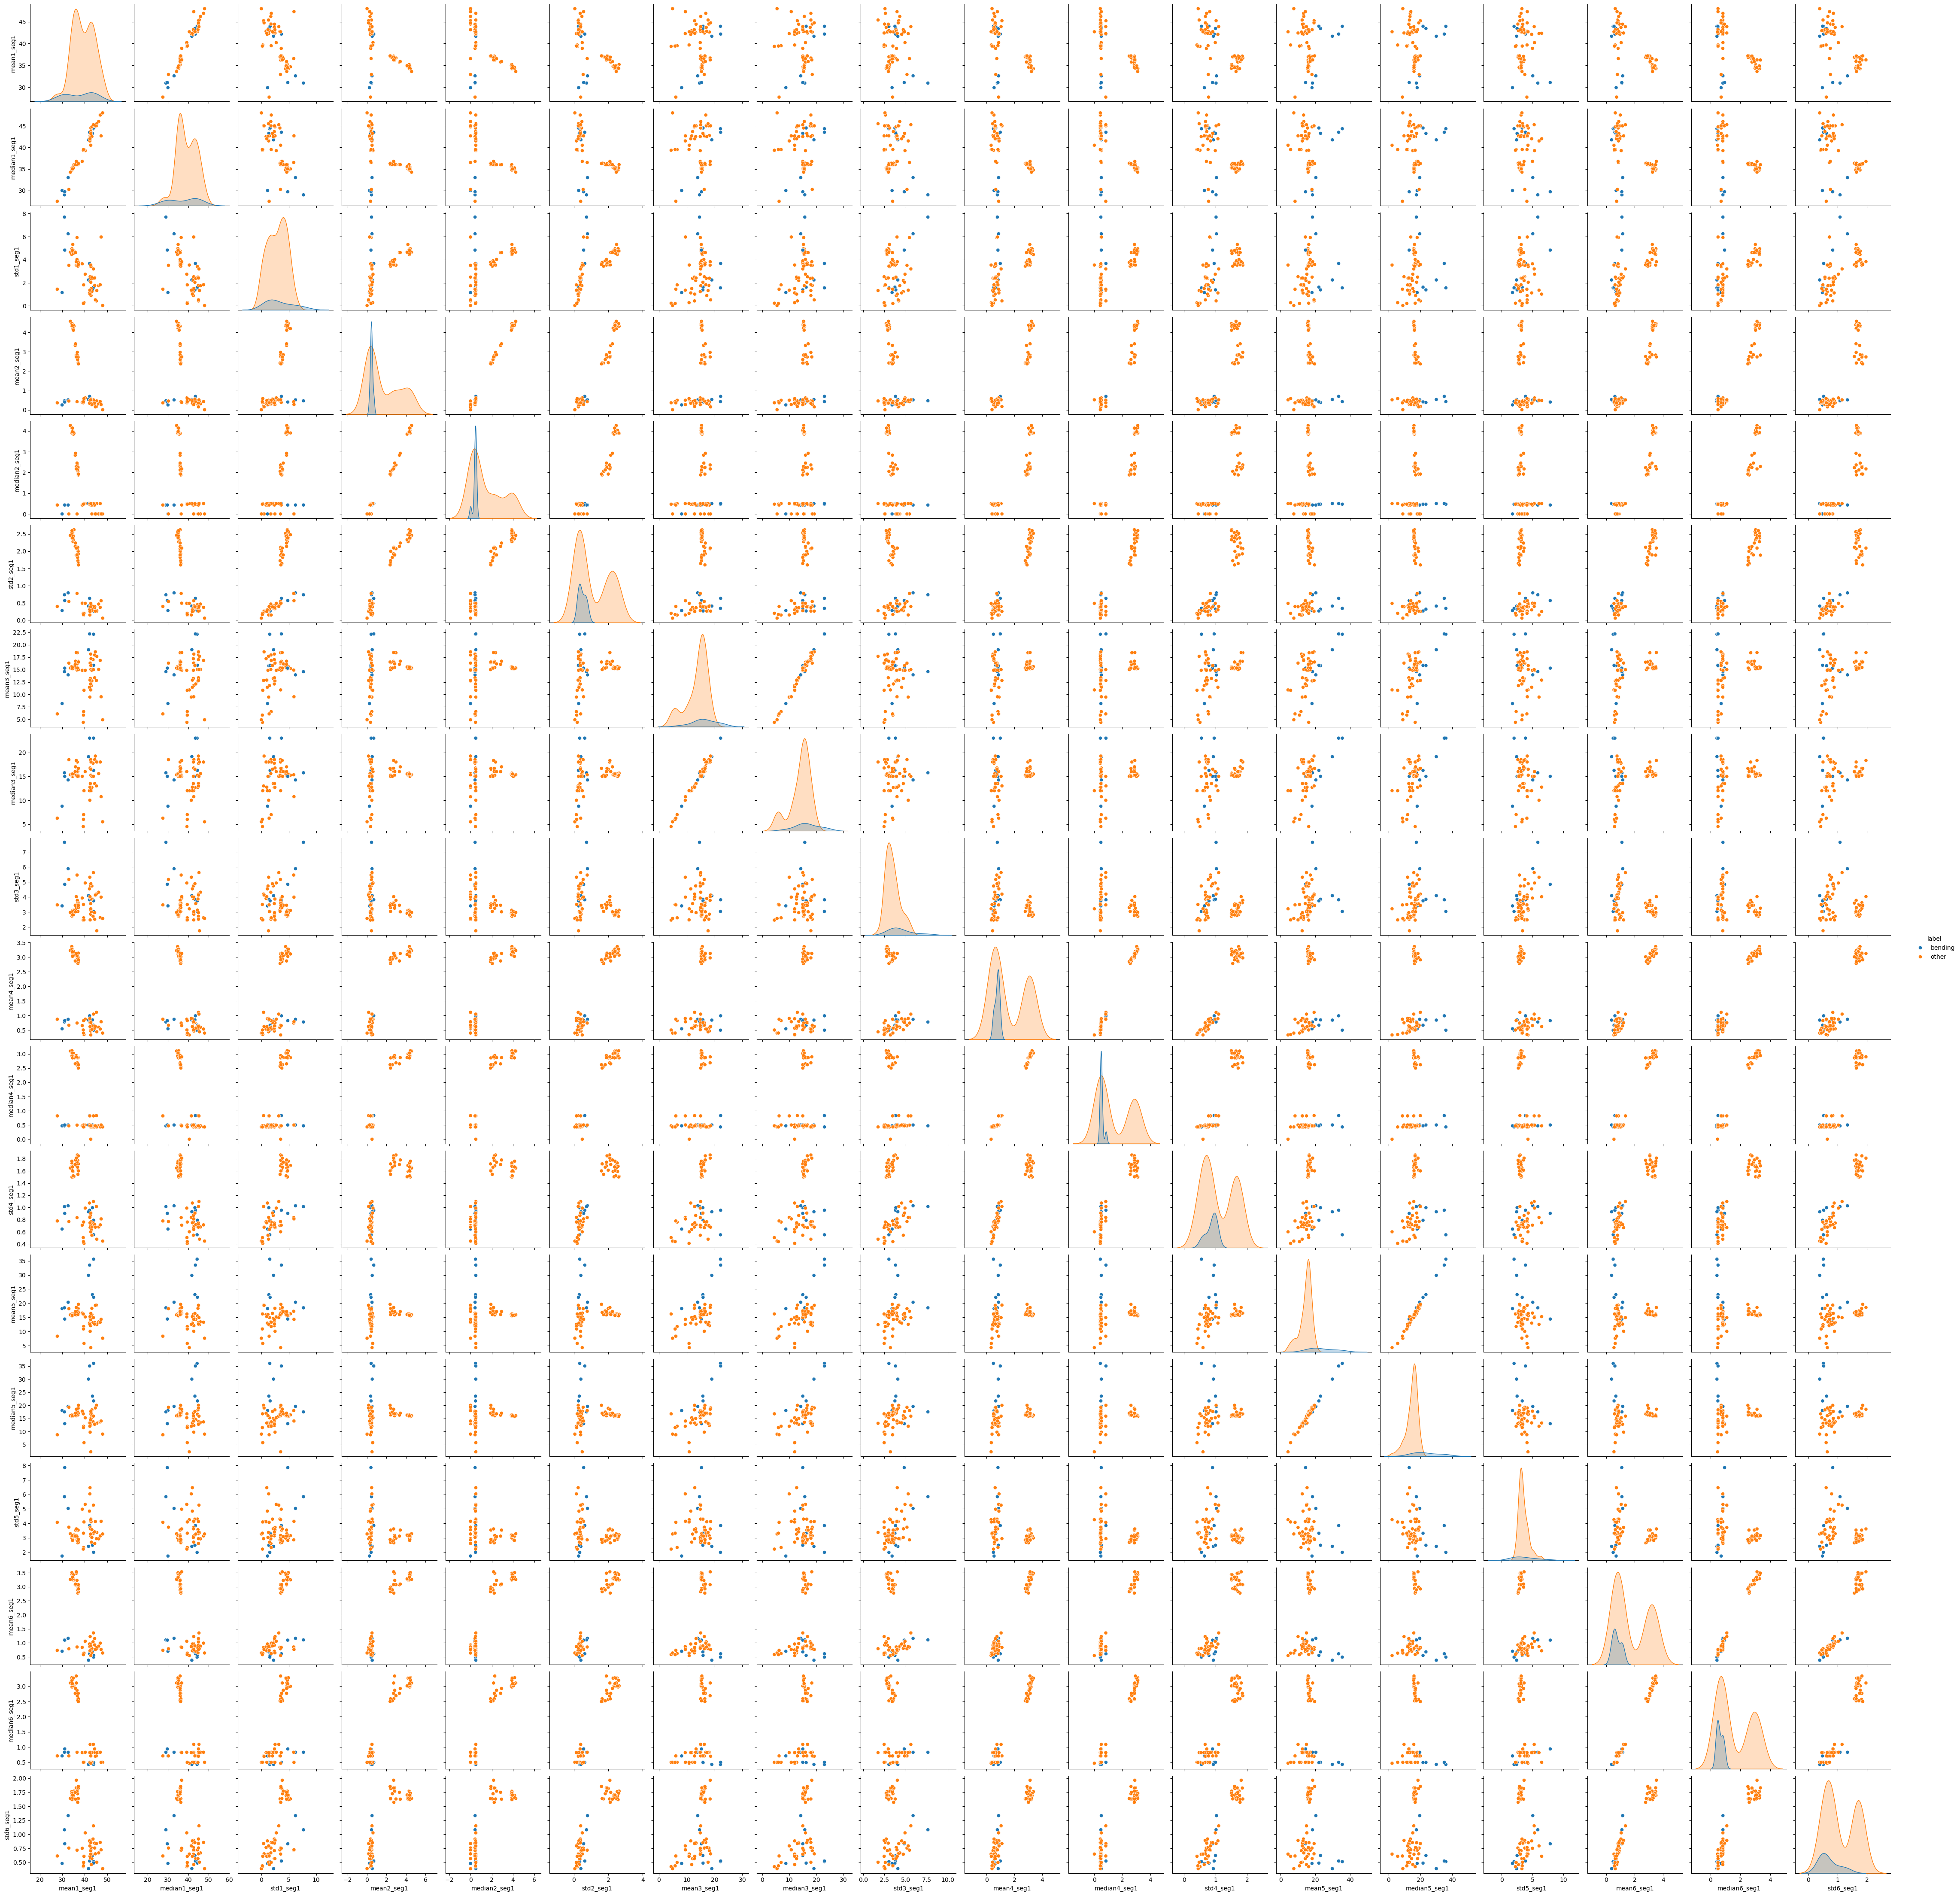

In [13]:
sns.pairplot(df_train_feature, hue = 'label')

---

##### Finding best combination of (l, p)
##### - Using cross validation and RFE to find the optimal combination of (l, p)
##### - However, RFE will use the whole training data to validate subset of features. Therefore, I use nested cross-validation to prevent data leakage during feature selection.
##### - In this method, every "l" will have five results of test score and optimal number of features, because spliting the validation set before REF

In [14]:
# defining function of logistic_regression with CV and RFECV
def nested_logistic_regression_eval(df_full_train, n_splits, solver, max_iter):
    """
    Using nested CV to fairly evaluate the feature set selected by RFECV.

    Args:
        df_full_train (pd.DataFrame): The complete training feature set for a specific value of 'l'.  
        n_splits (int): The number of splits for the outer cross-validation.  
        solver (str): The solver used in LogisticRegression.  
        max_iter (int): The maximum number of iterations for LogisticRegression.  
        
    Returns:
        tuple: (mean_outer_test_accuracy, mean_optimal_num_features, best_inner_accuracy_from_RFECV)
    """
    X_full = df_full_train.drop(columns='label').copy()
    y_full = df_full_train['label'].copy()
    
    outer_validator = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=77)
    outer_test_scores = []
    optimal_features_per_fold = []
    inner_rfecv_scores = [] 
    optimal_features_sets = []

    # Outer CV loop
    for train_index, test_index in outer_validator.split(X_full, y_full):
        
        # Split into: Outer Train (used for RFECV) and Outer Test (used for fair evaluation).
        X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
        y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

        # # -------------------------------
        # feature_columns_train = X_train.columns
        # feature_columns_test = X_test.columns
        
        # scaler = StandardScaler()
        # scaler.fit(X_train)
        # X_train = scaler.transform(X_train)
        # scaler.fit(X_test)
        # X_test = scaler.transform(X_test)

        # X_train = pd.DataFrame(X_train, columns=feature_columns_train)
        # X_test = pd.DataFrame(X_test, columns=feature_columns_test)
        # # --------------------------------


        # Iner CV (Using Outer train on REFCV to chose the optimal number of features)
        inner_validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)
        model = LogisticRegression(solver=solver, max_iter=max_iter)
        
        # Only use Outer train  when selecting features
        selector = RFECV(estimator=model, cv=inner_validator, scoring='accuracy')
        selector.fit(X_train, y_train)
        
        # Requiring optimal features set 
        optimal_features = X_train.columns[selector.support_]
        optimal_features_sets.append(optimal_features.tolist())
        
        # training final model through Outer Train and its selected features
        final_model = LogisticRegression(solver=solver, max_iter=max_iter)
        final_model.fit(X_train[optimal_features], y_train)
        
        # evaluation and prediction
        y_pred = final_model.predict(X_test[optimal_features])
        outer_score = accuracy_score(y_test, y_pred)
        
        outer_test_scores.append(outer_score)
        optimal_features_per_fold.append(selector.n_features_)
        inner_rfecv_scores.append(selector.cv_results_['mean_test_score'].max())


    # Result
    mean_outer_test_accuracy = np.mean(outer_test_scores)
    mean_optimal_num_features = np.mean(optimal_features_per_fold)
    
    return mean_outer_test_accuracy, mean_optimal_num_features, np.mean(inner_rfecv_scores), optimal_features_sets


In [15]:
LR_Result = {'Split':[], 'Num of Features (RFECV Inner)':[], 'Accuracy (Outer CV)':[], 'Accuracy (RFECV Inner)':[]}
Max_split = 20 
n_splits_outer = 5

for seg in range(1, Max_split + 1):
    df_train_feature = FE.get_features(data_type='train', l=seg)

    mean_accuracy, mean_optimal_num_features, mean_inner_score, optimal_features_sets = nested_logistic_regression_eval(
        df_train_feature, n_splits=n_splits_outer, solver='liblinear', max_iter=500
    )
    
    LR_Result['Split'].append(seg)
    LR_Result['Num of Features (RFECV Inner)'].append(round(mean_optimal_num_features))
    LR_Result['Accuracy (Outer CV)'].append(mean_accuracy.round(4))
    LR_Result['Accuracy (RFECV Inner)'].append(mean_inner_score.round(4))

LR_Result = pd.DataFrame(LR_Result)

print(LR_Result)
best_result = LR_Result.loc[LR_Result['Accuracy (Outer CV)'].idxmax()]
print(f"\n optimal (l, p) combination:")
print(f"l* (Split) = {best_result['Split']}")
print(f"p* (Num of Features) ≈ {best_result['Num of Features (RFECV Inner)']}")
print(f"Accuracy = {best_result['Accuracy (Outer CV)']}")

    Split  Num of Features (RFECV Inner)  Accuracy (Outer CV)  \
0       1                              7               0.9600   
1       2                             11               0.9190   
2       3                             10               0.9057   
3       4                             12               0.9733   
4       5                             18               0.9600   
5       6                             10               0.9457   
6       7                              7               0.9600   
7       8                              8               0.9467   
8       9                              9               0.9467   
9      10                              5               0.9600   
10     11                             20               0.9457   
11     12                             13               0.9600   
12     13                              6               0.9590   
13     14                              7               0.9733   
14     15                

----

##### (iv) Confusion Matrix

In [16]:
# l = 4
df_train_feature = FE.get_features(data_type='train', l=4)
df_test_feature = FE.get_features(data_type='test', l=4)

In [17]:
mean_accuracy, mean_optimal_num_features, mean_inner_score, optimal_features_sets = nested_logistic_regression_eval(
        df_train_feature, n_splits=n_splits_outer, solver='liblinear', max_iter=500
    )

print(f"accuracy : {mean_accuracy}")
print(f"mean_optimal_num_features : {mean_optimal_num_features}")
print(f"optimal_features_sets : {optimal_features_sets}")

accuracy : 0.9733333333333334
mean_optimal_num_features : 12.0
optimal_features_sets : [['median1_seg3', 'median3_seg1', 'mean4_seg2', 'mean4_seg3', 'mean5_seg1', 'median5_seg1', 'std5_seg1', 'mean6_seg3'], ['std1_seg1', 'mean1_seg3', 'mean5_seg1', 'mean6_seg4'], ['median1_seg3', 'std1_seg3', 'mean4_seg3', 'mean5_seg1', 'mean6_seg2'], ['std1_seg1', 'mean1_seg3', 'median1_seg3', 'std1_seg3', 'mean1_seg4', 'mean2_seg1', 'mean2_seg3', 'mean2_seg4', 'median3_seg1', 'std3_seg1', 'mean3_seg3', 'median3_seg3', 'median3_seg4', 'mean4_seg2', 'median4_seg2', 'mean4_seg3', 'median4_seg3', 'mean4_seg4', 'median4_seg4', 'mean5_seg1', 'median5_seg1', 'std5_seg1', 'mean5_seg2', 'std5_seg2', 'mean5_seg3', 'std5_seg3', 'mean5_seg4', 'median5_seg4', 'std5_seg4', 'mean6_seg1', 'median6_seg1', 'mean6_seg2', 'median6_seg2', 'mean6_seg3', 'median6_seg3', 'mean6_seg4', 'median6_seg4'], ['median1_seg3', 'std1_seg3', 'mean5_seg1', 'std5_seg3', 'mean5_seg4', 'mean6_seg2']]


##### Chosing 12 the most frequent features from five sets of optimal_features

In [18]:
all_selected_features = list(itertools.chain.from_iterable(optimal_features_sets))

# calculate frequency
feature_counts = Counter(all_selected_features)

top_features_with_counts = feature_counts.most_common(12)

top_features = [feature for feature, count in top_features_with_counts]

print("--- Chosing the most frequent features ---")
for i, (feature, count) in enumerate(top_features_with_counts):
    print(f"{i+1:2}. features: {feature:20} | count: {count} / 5")

print("\n------------------------------")
print("final features set")
print(top_features)

--- Chosing the most frequent features ---
 1. features: mean5_seg1           | count: 5 / 5
 2. features: median1_seg3         | count: 4 / 5
 3. features: mean4_seg3           | count: 3 / 5
 4. features: std1_seg3            | count: 3 / 5
 5. features: mean6_seg2           | count: 3 / 5
 6. features: median3_seg1         | count: 2 / 5
 7. features: mean4_seg2           | count: 2 / 5
 8. features: median5_seg1         | count: 2 / 5
 9. features: std5_seg1            | count: 2 / 5
10. features: mean6_seg3           | count: 2 / 5
11. features: std1_seg1            | count: 2 / 5
12. features: mean1_seg3           | count: 2 / 5

------------------------------
final features set
['mean5_seg1', 'median1_seg3', 'mean4_seg3', 'std1_seg3', 'mean6_seg2', 'median3_seg1', 'mean4_seg2', 'median5_seg1', 'std5_seg1', 'mean6_seg3', 'std1_seg1', 'mean1_seg3']


In [23]:
df_train_featureExtrac = FE.get_features(data_type='train', l=4)

X = df_train_featureExtrac[top_features]
y = df_train_featureExtrac['label']
y = np.where(y == 'bending', 1, 0)

X_with_const = sm.add_constant(X, prepend=False) 

sm_model = sm.Logit(y, X_with_const).fit(
    method='newton',  
    maxiter=100    
)

print(sm_model.summary())

         Current function value: 0.000000
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   74
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                           12
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                   1.000
Time:                        23:39:49   Log-Likelihood:            -3.1846e-12
converged:                      False   LL-Null:                       -27.391
Covariance Type:            nonrobust   LLR p-value:                 1.981e-07
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
mean5_seg1      22.6664   4.08e+11   5.56e-11      1.000   -7.99e+11    7.99e+11
median1_seg3   -13.8481   1.39e+11  -9.98e-11      1.000  

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/p

##### Complete Separation: The results show that there is complete separation. In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified.

In [24]:
df_train_feature = FE.get_features(data_type='train', l=4)
df_test_feature = FE.get_features(data_type='test', l=4)

X_train = df_train_feature[top_features]
y_train = df_train_feature['label']

X_test = df_test_feature[top_features]
y_test = df_test_feature['label']

model = LogisticRegression(solver='liblinear', max_iter=50)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_score = model.predict_proba(X_train)[:, 1]

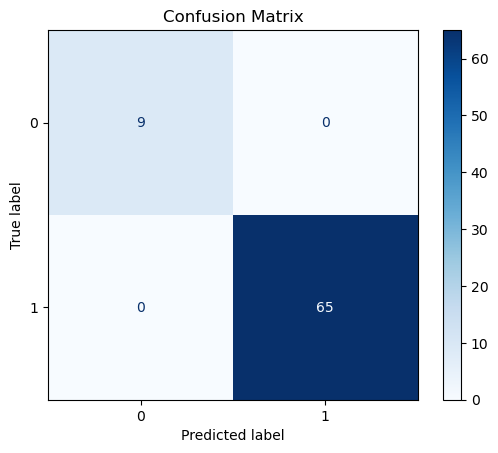

In [25]:
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

AUC: 1.0


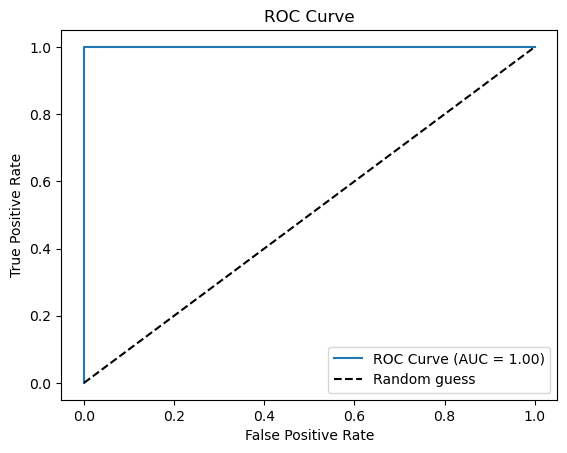

In [26]:
fpr, tpr, thresholds = roc_curve(y_train, y_score, pos_label='other')

auc = roc_auc_score(y_train, y_score)
print("AUC:", auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

---

##### (v) Test the classifier on the test set.

In [27]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

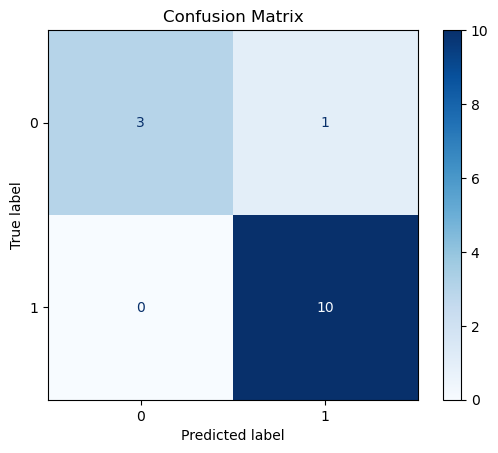

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

AUC: 1.0


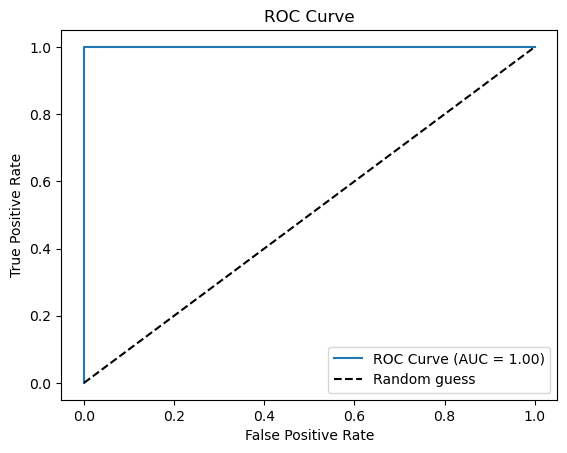

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='other')

auc = roc_auc_score(y_test, y_score)
print("AUC:", auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

##### The accuracy for train and test are the same
--- 

In [30]:
df_train_feature = FE.get_features(data_type='train', l=11)
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train = df_train_feature[top_features]
y_train = df_train_feature['label']

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("original training data:", y_train.value_counts())
print("SMOTE training data:", y_train_smote.value_counts())

original training data: label
other      65
bending     9
Name: count, dtype: int64
SMOTE training data: label
bending    65
other      65
Name: count, dtype: int64


In [31]:
model = LogisticRegression(solver='liblinear', max_iter=50)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_train_smote)
y_score = model.predict_proba(X_train_smote)[:, 1]

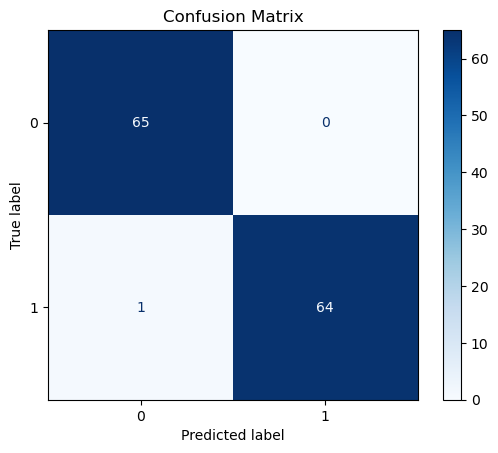

In [32]:
cm = confusion_matrix(y_train_smote, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

AUC: 1.0


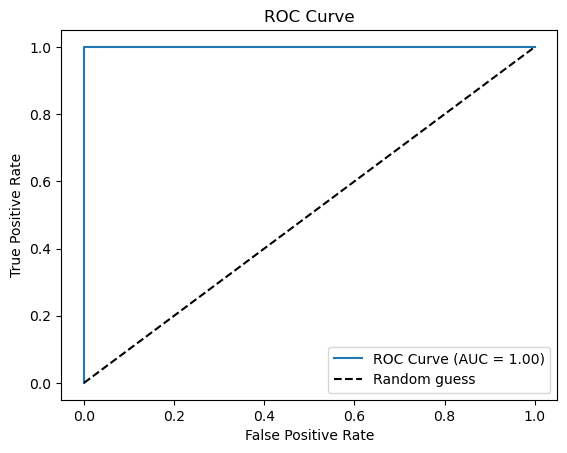

In [33]:
fpr, tpr, thresholds = roc_curve(y_train_smote, y_score, pos_label='other')

auc = roc_auc_score(y_train_smote, y_score)
print("AUC:", auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

---

### (b) Binary Classification Using L1-penalized logistic regression

In [34]:
def nested_logistic_regression_eval_L1(df_full_train, n_splits, l1_solver, max_iter):
    """
    Use nested cross-validation with L1 regularization (GridSearchCV over C) to evaluate the feature set.

    Args:
        df_full_train (pd.DataFrame): The complete training feature set corresponding to a specific value of 'l'.  
        n_splits (int): The number of splits for the outer cross-validation.  
        l1_solver (str): The solver that supports L1 regularization (e.g., 'liblinear' or 'saga').  
        max_iter (int): The maximum number of iterations.  

    Returns:
        tuple: (mean_outer_test_accuracy, mean_selected_features, mean_optimal_C)

    """
    X_full = df_full_train.drop(columns='label').copy()
    y_full = df_full_train['label'].copy()
    
    scaler = StandardScaler()
    X_full_scaled = scaler.fit_transform(X_full)
    X_full_scaled = pd.DataFrame(X_full_scaled, columns=X_full.columns)
    
    outer_validator = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=77)
    outer_test_scores = []
    selected_features_per_fold = []
    optimal_C_per_fold = []
    
    param_grid = {'C': np.logspace(-3, 3, 7)} # 0.001, 0.01, 0.1, 1, 10, 100, 1000

    for train_index, test_index in outer_validator.split(X_full_scaled, y_full):
        
        X_train, X_test = X_full_scaled.iloc[train_index], X_full_scaled.iloc[test_index]
        y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

        inner_validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)
        l1_model = LogisticRegression(penalty='l1', solver=l1_solver, max_iter=max_iter, random_state=77)

        grid_search = GridSearchCV(
            estimator=l1_model, 
            param_grid=param_grid, 
            scoring='accuracy', 
            cv=inner_validator, 
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        best_C = grid_search.best_params_['C']
        optimal_C_per_fold.append(best_C)
        
        final_l1_model = LogisticRegression(
            C=best_C, 
            penalty='l1', 
            solver=l1_solver, 
            max_iter=max_iter, 
            random_state=77
        )
        final_l1_model.fit(X_train, y_train)

        selected_features_indices = (final_l1_model.coef_[0] != 0)
        selected_features_count = np.sum(selected_features_indices)
        selected_features_per_fold.append(selected_features_count)

        y_pred = final_l1_model.predict(X_test)
        outer_score = accuracy_score(y_test, y_pred)
        outer_test_scores.append(outer_score)

    mean_outer_test_accuracy = np.mean(outer_test_scores)
    mean_selected_features = np.mean(selected_features_per_fold)
    mean_optimal_C = np.mean(optimal_C_per_fold)
    
    return mean_outer_test_accuracy, mean_selected_features, mean_optimal_C

In [35]:
LR_L1_Result = {'Split (l)':[], 'C (Inner CV)':[], 'Num of Selected Features':[], 'Accuracy (Outer CV)':[]}
Max_split = 20 
n_splits_outer = 5

for seg in range(1, Max_split + 1):

    df_train_feature = FE.get_features(data_type='train', l=seg)
    
    mean_accuracy, mean_selected_features, mean_optimal_C = nested_logistic_regression_eval_L1(
        df_train_feature, n_splits=n_splits_outer, l1_solver='liblinear', max_iter=2000)
 
    LR_L1_Result['Split (l)'].append(seg)
    LR_L1_Result['C (Inner CV)'].append(mean_optimal_C.round(4))
    LR_L1_Result['Num of Selected Features'].append(round(mean_selected_features))
    LR_L1_Result['Accuracy (Outer CV)'].append(mean_accuracy.round(4))

LR_L1_Result = pd.DataFrame(LR_L1_Result)

print(LR_L1_Result)
best_result_l1 = LR_L1_Result.loc[LR_L1_Result['Accuracy (Outer CV)'].idxmax()]

print(f"\n L1 regularization's optimal (l, C, p) 組合:")
print(f"l* (Split) = {best_result_l1['Split (l)']}")
print(f"C* (L1 Penalty) ≈ {best_result_l1['C (Inner CV)']}")
print(f"p* (Num of Features) ≈ {best_result_l1['Num of Selected Features']}")
print(f"Accuracy = {best_result_l1['Accuracy (Outer CV)']}")

    Split (l)  C (Inner CV)  Num of Selected Features  Accuracy (Outer CV)
0           1           4.6                         5               0.9333
1           2           2.8                         7               0.9190
2           3          22.6                         7               0.9457
3           4          24.4                        10               0.9457
4           5          42.4                        11               0.9190
5           6           1.0                         8               0.9590
6           7           1.0                         9               0.9324
7           8         402.4                        23               0.9190
8           9           4.6                        12               0.9057
9          10         202.6                        19               0.9190
10         11          22.6                        13               0.9324
11         12          40.6                        17               0.9324
12         13           2

---

### Comparision with p-value method

In [36]:
best_result_l1 = LR_L1_Result.loc[LR_L1_Result['Accuracy (Outer CV)'].idxmax()]

l_star = int(best_result_l1['Split (l)'])
C_star = best_result_l1['C (Inner CV)'] 

df_final_train = FE.get_features(data_type='train', l=l_star) 

X_final_full = df_final_train.drop(columns='label').copy()
y_final_full = df_final_train['label'].copy()
feature_names = X_final_full.columns

scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final_full)

final_l1_model = LogisticRegression(
    C=C_star, 
    penalty='l1', 
    solver='liblinear', 
    max_iter=1000, 
    random_state=77
)

final_l1_model.fit(X_final_scaled, y_final_full)

LogisticRegression(C=np.float64(2.8), max_iter=1000, penalty='l1',
                   random_state=77, solver='liblinear')

In [37]:
l1_coefs = final_l1_model.coef_[0]

selected_indices = np.where(l1_coefs != 0)[0]

selected_features_l1 = feature_names[selected_indices].tolist()

print(f"number of split l*: {l_star}")
print(f"penalty level C*: {C_star}")
print(f"L1 number of selected features (p*): {len(selected_features_l1)}")
print("\n--- L1 selected features list ---")
print(selected_features_l1)

number of split l*: 13
penalty level C*: 2.8
L1 number of selected features (p*): 12

--- L1 selected features list ---
['median1_seg8', 'std3_seg3', 'mean3_seg5', 'std3_seg6', 'std3_seg10', 'std3_seg11', 'median4_seg10', 'mean5_seg2', 'median5_seg2', 'mean5_seg4', 'mean5_seg12', 'std6_seg12']



--- model performance analyze(on testing data) ---
l*: 13
L1 number of selected number: 12
----------------------------------------
Confusion Matrix:
[[10  0]
 [ 1  3]]
True Negative (TN): 10, False Positive (FP): 0
False Negative (FN): 1, True Positive (TP): 3
----------------------------------------
Accuracy: 0.9286
ROC AUC: 1.0000


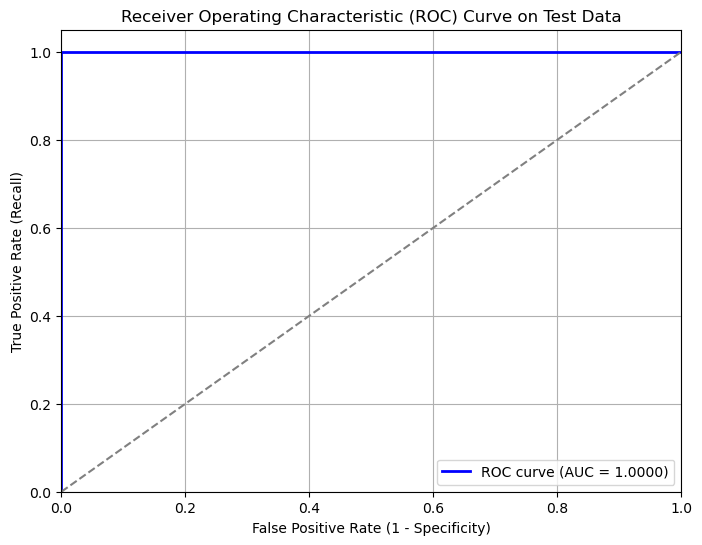


--- Beta i's ---
      Feature  Coefficient (Beta)
    Intercept            4.282134
 median1_seg8            0.932129
    std3_seg3           -0.003661
   mean3_seg5            0.060756
    std3_seg6            0.167851
   std3_seg10            0.105484
   std3_seg11            0.069732
median4_seg10            0.130023
   mean5_seg2           -2.905171
 median5_seg2            0.000000
   mean5_seg4           -0.296835
  mean5_seg12           -0.712283
   std6_seg12            1.147969


In [38]:
df_final_test = FE.get_features(data_type='test', l=l_star) 

POSITIVE_LABEL = 'bending'
if df_final_test['label'].dtype == object:
    df_final_test['label'] = (df_final_test['label'] == POSITIVE_LABEL).astype(int)

X_test_full = df_final_test.drop(columns='label').copy()
y_test = df_final_test['label'].copy()

X_test_scaled_all = scaler.transform(X_test_full)
X_test_scaled_all = pd.DataFrame(X_test_scaled_all, columns=X_test_full.columns)

X_test_final_scaled = X_test_scaled_all[selected_features_l1]

X_train_scaled_all = scaler.transform(X_final_full)
X_train_scaled_all = pd.DataFrame(X_train_scaled_all, columns=X_final_full.columns)
X_train_final_scaled = X_train_scaled_all[selected_features_l1]


final_model = LogisticRegression(
    C=C_star, 
    penalty='l1',
    solver='liblinear', 
    max_iter=1000, 
    random_state=77
)

final_model.fit(X_train_final_scaled, y_final_full)

# predicted class labels (strings) from the model
y_pred_class = final_model.predict(X_test_final_scaled)

# convert predicted class labels to numeric (0/1) using POSITIVE_LABEL so they match y_test
y_pred_class_num = (y_pred_class == POSITIVE_LABEL).astype(int)

# find the column index for the positive class in predict_proba output
pos_idx = list(final_model.classes_).index(POSITIVE_LABEL)
y_pred_proba = final_model.predict_proba(X_test_final_scaled)[:, pos_idx]

cm = confusion_matrix(y_test, y_pred_class_num)
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_test, y_pred_class_num)

print("\n--- model performance analyze(on testing data) ---")
print(f"l*: {l_star}")
print(f"L1 number of selected number: {len(selected_features_l1)}")
print("-" * 40)
print("Confusion Matrix:")
print(cm)
print(f"True Negative (TN): {tn}, False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}, True Positive (TP): {tp}")
print("-" * 40)
print(f"Accuracy: {accuracy:.4f}")

auc_score = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

print(f"ROC AUC: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve on Test Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n--- Beta i's ---")
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features_l1,
    'Coefficient (Beta)': [final_model.intercept_[0]] + final_model.coef_[0].tolist()
})
print(coef_df.to_string(index=False))

##### L1 regularization has worse performance on accuracy, but it is easier to implement feature selection.
---

## (c) Multi-class Classification (The Realistic Case)

In [68]:
# defining a function to satisfy spliting data into multiple series and change into extraction data.
class FeatExtrac():
    
    def __init__(self, base_path_str="../data/AReM"):
        self.BasePath = Path(base_path_str)
        
        if not self.BasePath.exists():
            print(f"Error: Base Path {self.BasePath} doesn't exist.")
            self.dir_list = []
        else:
            self.dir_list = [d for d in self.BasePath.iterdir() if d.is_dir()]

        self.actName = [os.path.basename(os.path.normpath(d)) for d in self.dir_list]
        
        self.DirPath = {}
        for d in self.dir_list:
            activity = os.path.basename(os.path.normpath(d))
            self.DirPath[activity] = d
        

    def get_features(self, data_type='train', l=1):
        """
        Extracts features (mean, median, std) from time series data.

        Args:
            data_type (str): 'train' or 'test' to specify which dataset to process.
            l (int): The number of segments to split each time series into. 
                     Default is 1 (no split).

        Returns:
            pandas.DataFrame: A DataFrame containing the extracted features and the 'label' column.
        """
        
        feature_names = ["mean", "median", "std"]
 
        feature_columns = []
        for i in range(1, 7): 
            for j in range(1, l + 1): 
                for feat in feature_names:
                    feature_columns.append(f"{feat}{i}_seg{j}")
        
        all_data_list = [] 

        for activity, path in self.DirPath.items():

            # bending 1 & bending2
            if activity == 'bending1':
                file_indices = range(3, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 3)
                label = 'bending1'
            elif activity == 'bending2':
                file_indices = range(3, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 3)
                label = 'bending2'
                
            # walking, standing, sitting, lying, cycling
            elif activity == 'walking':
                file_indices = range(4, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 4)
                label = 'walking'
            elif activity == 'standing':
                file_indices = range(4, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 4)
                label = 'standing'
            elif activity == 'sitting':
                file_indices = range(4, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 4)
                label = 'sitting'
            elif activity == 'lying':
                file_indices = range(4, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 4)
                label = 'lying'
            else:
                file_indices = range(4, len(os.listdir(path)) + 1) if data_type == 'train' else range(1, 4)
                label = 'cycling'

            for i in file_indices:
                file_path = path / f"dataset{i}.csv"
                if not file_path.exists():
                    continue
                
                try:
        
                    # data = pd.read_csv(file_path, skiprows=4)
                    data = pd.read_csv(file_path, skiprows=5, sep=r'[,\s]+', header=None, engine='python')
                    # data = data.drop(columns=["# Columns: time"])
                    data = data.drop(columns=[0])
                except Exception as e:
                    print(f"Could not read {file_path}: {e}")
                    continue

                instance_features = []
                
                for col_name in data.columns:
                    time_series = data[col_name]
                    
                    if l > 1:
                        segments = np.array_split(time_series, l)
                    else:
                        segments = [time_series]
                    
                    for seg in segments:
    
                        if not seg.empty:
                            feats = [seg.mean(), seg.median(), seg.std()]
                            instance_features.extend(feats)
                        
                all_data_list.append(instance_features + [label])
        
        final_columns = feature_columns + ['label']

        features_df = pd.DataFrame(all_data_list, columns=final_columns)
        
        # features_df.insert(0, 'instance', range(1, len(features_df) + 1))
        
        return features_df

In [69]:
def nested_multinomial_L1_eval(df_full_train, n_splits_outer, max_iter, C_candidates):
    X_full = df_full_train.drop(columns='label').copy()
    y_full = df_full_train['label'].copy()
    
    if X_full.shape[1] == 0:
        return 0.0, 0.0, np.nan
    
    outer_validator = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=77)
    outer_test_scores = []
    selected_features_per_fold = []
    optimal_C_per_fold = []
    
    for fold, (train_index, test_index) in enumerate(outer_validator.split(X_full, y_full)):
        
        X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
        y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        
        inner_validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)
        l1_model = LogisticRegression(
            penalty='l1', 
            solver='saga', 
            multi_class='multinomial', 
            max_iter=max_iter, 
            random_state=77
        )
        
        grid_search = GridSearchCV(
            estimator=l1_model, 
            param_grid={'C': C_candidates}, 
            scoring='accuracy', 
            cv=inner_validator, 
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, y_train)
        
        best_C = grid_search.best_params_['C']
        optimal_C_per_fold.append(best_C)
        
        final_l1_model = LogisticRegression(
            C=best_C, 
            penalty='l1', 
            solver='saga', 
            multi_class='multinomial', 
            max_iter=max_iter, 
            random_state=77
        )
        final_l1_model.fit(X_train_scaled, y_train)
        
        non_zero_features = (np.abs(final_l1_model.coef_).sum(axis=0) != 0)
        selected_features_count = np.sum(non_zero_features)
        selected_features_per_fold.append(selected_features_count)

        y_pred = final_l1_model.predict(X_test_scaled)
        outer_score = accuracy_score(y_test, y_pred)
        outer_test_scores.append(outer_score)

    mean_outer_test_accuracy = np.mean(outer_test_scores)
    mean_selected_features = np.mean(selected_features_per_fold)
    mean_optimal_C = np.mean(optimal_C_per_fold)
    
    return mean_outer_test_accuracy, mean_selected_features, mean_optimal_C

In [70]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
FE = FeatExtrac()

Max_split = 20 
n_splits_outer = 5
max_iter_saga = 2000 
C_candidates_l1 = np.logspace(-3, 2, 6) # [0.001, 0.01, 0.1, 1, 10, 100]

LR_Multi_L1_Result = {'Split (l)':[], 'C (Inner CV)':[], 'Num of Features':[], 'Accuracy (Outer CV)':[]}

for seg in range(1, Max_split + 1):
    df_train_feature = FE.get_features(data_type='train', l=seg)

    mean_accuracy, mean_selected_features, mean_optimal_C = nested_multinomial_L1_eval(
        df_train_feature, n_splits_outer=n_splits_outer, max_iter=max_iter_saga, C_candidates=C_candidates_l1
    )
    
    LR_Multi_L1_Result['Split (l)'].append(seg)
    LR_Multi_L1_Result['C (Inner CV)'].append(mean_optimal_C)
    LR_Multi_L1_Result['Num of Features'].append(round(mean_selected_features))
    LR_Multi_L1_Result['Accuracy (Outer CV)'].append(mean_accuracy)

LR_Multi_L1_Result_df = pd.DataFrame(LR_Multi_L1_Result)

best_result_multi = LR_Multi_L1_Result_df.loc[LR_Multi_L1_Result_df['Accuracy (Outer CV)'].idxmax()]

l_star_L1 = int(best_result_multi['Split (l)'])
C_star_L1 = best_result_multi['C (Inner CV)']

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/si

In [71]:
print("--- L1-penalized multinomial Hyperparameter ---")
print(f"l* (Split) = {l_star_L1}")
print(f"C* (L1 Penalty) ≈ {C_star_L1:.4f}")

--- L1-penalized multinomial Hyperparameter ---
l* (Split) = 1
C* (L1 Penalty) ≈ 24.4000


In [72]:
df_train = FE.get_features(data_type='train', l=l_star_L1)
df_test = FE.get_features(data_type='test', l=l_star_L1)

X_train = df_train.drop(columns='label')
y_train = df_train['label']
X_test = df_test.drop(columns='label')
y_test = df_test['label']

scaler_L1 = StandardScaler()
X_train_scaled = scaler_L1.fit_transform(X_train)
X_test_scaled = scaler_L1.transform(X_test)

model_L1 = LogisticRegression(
    C=C_star_L1, 
    penalty='l1', 
    solver='saga', 
    multi_class='multinomial', 
    max_iter=2000, 
    random_state=77
)
model_L1.fit(X_train_scaled, y_train)

y_pred_L1 = model_L1.predict(X_test_scaled)
test_accuracy_L1 = accuracy_score(y_test, y_pred_L1)
test_error_L1 = 1 - test_accuracy_L1

print(f"L1 mutiple regression (l*={l_star_L1}, C*={C_star_L1}) test error : {test_error_L1:.4f}")

L1 mutiple regression (l*=1, C*=24.4) test error : 0.0526


[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


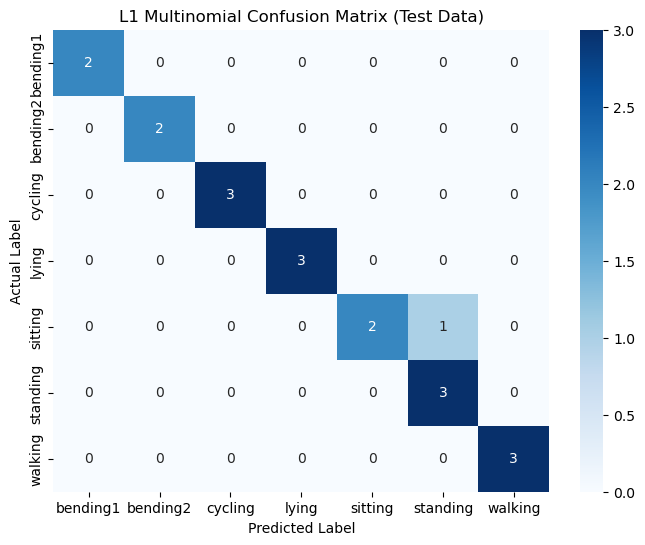

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_L1 = confusion_matrix(y_test, y_pred_L1)
activity_labels = model_L1.classes_ 

print(cm_L1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_L1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('L1 Multinomial Confusion Matrix (Test Data)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


L1 Macro-average AUC (OvR): 0.9911
L1 Micro-average AUC (OvR): 0.9954


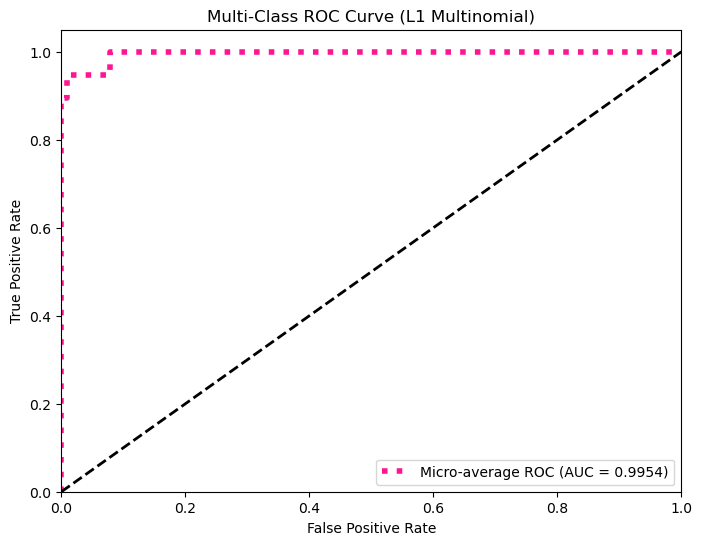

In [74]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer

y_proba_L1 = model_L1.predict_proba(X_test_scaled)

label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)
class_labels = label_binarizer.classes_

macro_auc_L1 = roc_auc_score(y_test_binarized, y_proba_L1, average='macro')
micro_auc_L1 = roc_auc_score(y_test_binarized, y_proba_L1, average='micro')

print(f"\nL1 Macro-average AUC (OvR): {macro_auc_L1:.4f}")
print(f"L1 Micro-average AUC (OvR): {micro_auc_L1:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(roc_curve(y_test_binarized.ravel(), y_proba_L1.ravel())[0], 
         roc_curve(y_test_binarized.ravel(), y_proba_L1.ravel())[1], 
         label=f'Micro-average ROC (AUC = {micro_auc_L1:.4f})', 
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (L1 Multinomial)')
plt.legend(loc="lower right")
plt.show()

---

### Use both Gaussian and Multinomial priors and compare the results.

In [75]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler

model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)

y_pred_gnb = model_gnb.predict(X_test)
error_gnb = 1 - accuracy_score(y_test, y_pred_gnb)

print(f"\nGaussian Naïve Bayes test error: {error_gnb:.4f}")

min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

model_mnb = MultinomialNB()
model_mnb.fit(X_train_minmax, y_train)

y_pred_mnb = model_mnb.predict(X_test_minmax)
error_mnb = 1 - accuracy_score(y_test, y_pred_mnb)

print(f"Multinomial Naïve Bayes test error: {error_mnb:.4f}")

y_proba_gnb = model_gnb.predict_proba(X_test)
y_proba_mnb = model_mnb.predict_proba(X_test_minmax)

macro_auc_gnb = roc_auc_score(y_test_binarized, y_proba_gnb, average='macro')
macro_auc_mnb = roc_auc_score(y_test_binarized, y_proba_mnb, average='macro')

print(f"Gaussian Naïve Bayes Macro-AUC: {macro_auc_gnb:.4f}")
print(f"Multinomial Naïve Bayes Macro-AUC: {macro_auc_mnb:.4f}")


Gaussian Naïve Bayes test error: 0.1579
Multinomial Naïve Bayes test error: 0.4211
Gaussian Naïve Bayes Macro-AUC: 0.9821
Multinomial Naïve Bayes Macro-AUC: 0.9435


---

### Which method is better for multi-class classification in this problem?

In [76]:
print("--L1-penalized multinomial regression--")
print(f"L1 mutiple regression test error : {test_error_L1:.4f}")
print(f"L1 Micro-average AUC (OvR): {micro_auc_L1:.4f}")

print("--Gaussian Naïve Bayes test error--")
print(f"\nGaussian Naïve Bayes test error: {error_gnb:.4f}")
print(f"Gaussian Naïve Bayes Macro-AUC: {macro_auc_gnb:.4f}")

print("--Multinomial Naïve Bayes test error--")
print(f"\nMultinomial Naïve Bayes test error: {error_mnb:.4f}")
print(f"Multinomial Naïve Bayes Macro-AUC: {macro_auc_mnb:.4f}")

--L1-penalized multinomial regression--
L1 mutiple regression test error : 0.0526
L1 Micro-average AUC (OvR): 0.9954
--Gaussian Naïve Bayes test error--

Gaussian Naïve Bayes test error: 0.1579
Gaussian Naïve Bayes Macro-AUC: 0.9821
--Multinomial Naïve Bayes test error--

Multinomial Naïve Bayes test error: 0.4211
Multinomial Naïve Bayes Macro-AUC: 0.9435


### The multinomial regression model has better performance on both accuracy and AUC than any other classifier prior.
### I consider that multinomial regression is a better classification on this given data.

---

# Reference
### https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
### https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
### https://scikit-learn.org/stable/modules/naive_bayes.html